In [26]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [27]:
# import numpy as np
import random
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import os
# np.random.seed(3)
random.seed(3)
torch.manual_seed(3)

# Data Augmentation



In [28]:
transform = {
    "train": transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.485,0.456,0.406], std = [0.229,0.224,0.225])
    ]),
    "Test": transforms.Compose({
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.485,0.456,0.406], std = [0.229,0.224,0.225])
    })
}

## Load Image Folder

In [29]:
root='/content/drive/My Drive/Colab Notebooks/Data/flowers/'

full_dataset = datasets.ImageFolder(os.path.join(root,'flowers'),transform=transform["train"])
class_names = full_dataset.classes
print('full dataset:',full_dataset)
print('Classes:',class_names)

full dataset: Dataset ImageFolder
    Number of datapoints: 4323
    Root location: /content/drive/My Drive/Colab Notebooks/Data/flowers/flowers
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.5, 1.5], contrast=None, saturation=None, hue=None)
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


# Split train val and test set

In [30]:
train_size = int(0.7 * len(full_dataset))
test_size = int((len(full_dataset) - train_size)/2)
val_size = len(full_dataset) - train_size - test_size

print('Train set:',train_size)
print('Validation set:',val_size)
print('Test set:',test_size)
train_data, val_data, test_data = torch.utils.data.random_split(
    full_dataset, 
    [train_size, val_size, test_size])

Train set: 3026
Validation set: 649
Test set: 648


In [31]:
train_btch_size = 32
val_btch_size = 16
test_btch_size = 16

train_loader = DataLoader(train_data,batch_size=train_btch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_data,batch_size=val_btch_size, shuffle=False, num_workers=8)
test_loader =  DataLoader(test_data,batch_size =test_btch_size, shuffle=False, num_workers=8)


# CNN

In [32]:
class ConvNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,1)
        self.conv2 = nn.Conv2d(32,64,3,1)
        self.conv3 = nn.Conv2d(64,128,3,1)
        self.fc1  = nn.Linear(128*26*26,16)
        self.fc2  = nn.Linear(16,8)
        self.fc3  = nn.Linear(8,5)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2)
        
        X = X.view(-1,128*26*26)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

In [33]:
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.drop_out = nn.Dropout(p=0.5)
        self.fc1   = nn.Linear(128*26*26,1024)
        self.fc2   = nn.Linear(1024,5)
        
    def forward(self,X):
        X = self.layer1(X)
        X = self.layer2(X)
        X = self.layer3(X)
        X = X.view(-1,128*26*26)
        X = self.drop_out(X)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return X

# Check GPU

> scheduler stands for learning rate decay.


In [34]:
# networks: ConvNet1,ConvNet2
net = ConvNet1()
criterion = nn.CrossEntropyLoss()
use_gpu = torch.cuda.is_available()
if use_gpu:
  net.cuda()
  criterion = criterion.cuda()
  # get gpu information
  device_id = torch.cuda.current_device()
  device_num = torch.cuda.device_count()
  device_name = torch.cuda.get_device_name(device_id)
  print("GPU available")
  print("Device name:",device_name)
  print("Device number:",device_num)
else:
  print("GPU not avaliable") 

# epoch
epochs = 10

# optimizer
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
print(net)

GPU available
Device name: Tesla T4
Device number: 1
ConvNet1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=86528, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=5, bias=True)
)


# Train and Test

`trn_corr+=(predicted == y_train).sum()`:<br>
`predicted` and `y_train` are matrixs of the same size (normally (1,20)).<br>
`np.sum()` will calculate the total number of result that satisfy the condition. 
[source](https://note.nkmk.me/en/python-numpy-count/).

In [35]:
%%time
losses = {'train':[],'val':[]}
corrects = {'train':[],'val':[]}
for epoch in range(epochs):
  trn_corr = 0
  val_corr = 0
  trn_loss = 0
  val_loss = 0
  for batch,(X_train,y_train) in enumerate(train_loader):
    batch+=1
    if torch.cuda.is_available():
      X_train = Variable(X_train).cuda()
      y_train = Variable(y_train).cuda()
    
    y_pred = net(X_train)
    loss = criterion(y_pred,y_train)
    predicted =torch.max(y_pred.data,1)[1]
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    trn_loss += loss.item()*X_train.size(0)
    trn_corr += (predicted == y_train).sum()

    if batch%30 ==0:
        print(f'epoch:{epoch} batch:{batch} loss:{loss.item()} accuracy:{trn_corr.item()*100/(batch*train_btch_size)}')
        
  scheduler.step()    
  losses['train'].append(trn_loss/train_size)
  corrects['train'].append(trn_corr.item()/train_size*100)
    

  with torch.no_grad():
    for batch,(X_val,y_val) in enumerate(val_loader):
      if torch.cuda.is_available():
        X_val = Variable(X_val).cuda()
        y_val = Variable(y_val).cuda()

      output_val= net(X_val)
      predicted = torch.max(output_val.data,1)[1]
      loss = criterion(output_val,y_val)
      val_corr += (predicted==y_val).sum()
      val_loss += loss.item()*X_val.size(0)

    losses['val'].append(val_loss/val_size)
    corrects['val'].append(val_corr.item()/val_size*100) 
    

epoch:0 batch:30 loss:1.483284592628479 accuracy:25.104166666666668
epoch:0 batch:60 loss:1.4700591564178467 accuracy:27.135416666666668
epoch:0 batch:90 loss:1.346792459487915 accuracy:31.805555555555557
epoch:1 batch:30 loss:1.1791772842407227 accuracy:47.1875
epoch:1 batch:60 loss:1.1609094142913818 accuracy:51.145833333333336
epoch:1 batch:90 loss:1.6108254194259644 accuracy:52.11805555555556
epoch:2 batch:30 loss:0.8833292126655579 accuracy:58.541666666666664
epoch:2 batch:60 loss:0.9603007435798645 accuracy:60.260416666666664
epoch:2 batch:90 loss:1.012437343597412 accuracy:60.0
epoch:3 batch:30 loss:0.9914678931236267 accuracy:64.58333333333333
epoch:3 batch:60 loss:0.7889045476913452 accuracy:64.42708333333333
epoch:3 batch:90 loss:0.946064293384552 accuracy:64.72222222222223
epoch:4 batch:30 loss:0.9670524597167969 accuracy:66.45833333333333
epoch:4 batch:60 loss:0.897476851940155 accuracy:67.60416666666667
epoch:4 batch:90 loss:0.8320702314376831 accuracy:68.125
epoch:5 batch

## Save Model

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/Data/Models/"
torch.save(net.state_dict(),path)

# Visualize Result

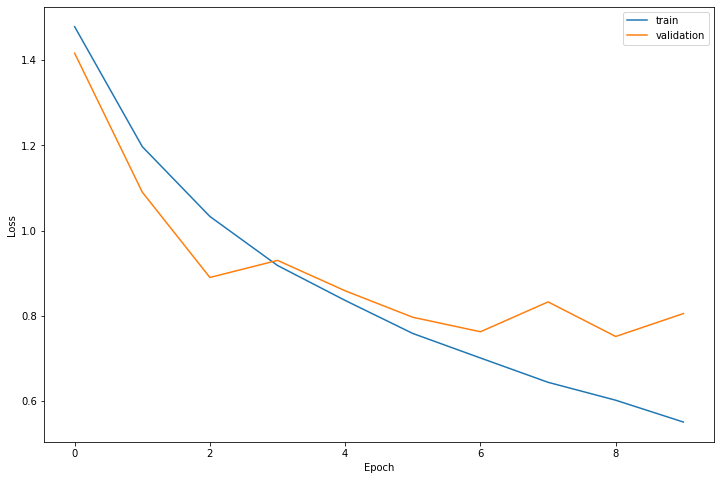

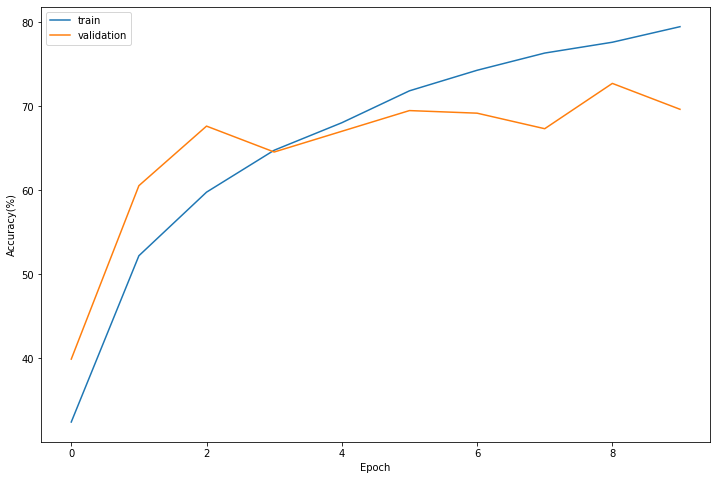

In [36]:
#  Plot train loss and val loss 
plt.figure(figsize=(12,8))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses['train'],label = 'train')
plt.plot(losses['val'],label  = 'validation')
plt.legend()

#  Plot train and val accuracy
plt.figure(figsize=(12,8))
plt.xlabel("Epoch")
plt.ylabel("Accuracy(%)")
plt.plot(corrects['train'],label = 'train')
plt.plot(corrects['val'], label = 'validation')
plt.legend()

## Accuracy on Testset


In [37]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    X,y = data
    if use_gpu:
      X = Variable(X).cuda()
      y = Variable(y).cuda()
    output = net(X)
    for idx, i in enumerate(output):
      if torch.argmax(i) == y[idx]:
          correct += 1
      total += 1
print("Accuracy: ", round(correct/total, 4))

Accuracy:  0.6852


## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
  cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis] # normalization
  plt.imshow(cm, interpolation='nearest')
  plt.title(title)
  plt.colorbar()
  num_local = np.array(range(len(class_names)))
  plt.xticks(num_local, class_names, rotation=90)
  plt.yticks(num_local, class_names)
  plt.ylabel('True label')    
  plt.xlabel('Predicted label')

In [ ]:
confusion_matrix()
